In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sktime
from sktime.datasets import load_from_tsfile
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
import torch

In [2]:
from ROCKET_implementation import RocketTransform, ClassifierModel

In [3]:
class Ham_Dataset(torch.utils.data.Dataset):
    def __init__(self, rocket_transform, tsfile='Ham/Ham_TRAIN.ts'):
        super().__init__()

        x, y = load_from_tsfile(tsfile)

        X = []
        for sample_id in range(len(x['dim_0'])):
            X.append(list(x['dim_0'][sample_id]))

        self.Scaler = StandardScaler()
        X = self.Scaler.fit_transform(X)

        self.X = rocket_transform(torch.tensor(np.array(X)))
        self.Y = np.array(y).astype(int) - 1
    
    def __getitem__(self, index):
        return torch.tensor(self.X[index]), torch.tensor(self.Y[index])
    
    def __len__(self):
        return len(self.X)

In [4]:
rt_transform = RocketTransform(num_kernels=10000, input_length=431, device='cpu', generation_type='normal')

/Users/matvei_anosin/Desktop/Skoltech Interview /1/ROCKET_implementation.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0, torch.log2(torch.tensor((input_length - 1) / (length - 1), device=self.device))


In [5]:
ham_train_dataset = Ham_Dataset(rt_transform)
train_dataloader = torch.utils.data.DataLoader(ham_train_dataset, batch_size=16)

ham_test_dataset = Ham_Dataset(rt_transform, tsfile='Ham/Ham_TEST.ts')
test_dataloader =  torch.utils.data.DataLoader(ham_test_dataset, batch_size=len(ham_test_dataset))

In [6]:
def trainer(model, criterion, optimizer, epochs, device='cpu'):
    losses        = []
    test_accuracy = []

    for epoch in tqdm(range(epochs)):
        loss_epoch = []
        for (x_batch, y_batch) in train_dataloader:
            optimizer.zero_grad()

            x_batch = x_batch.to(device).to(torch.float32) 
            y_batch = y_batch.to(device).to(torch.float32) 

            y_pred = model(x_batch)                        
            loss   = criterion(y_pred.flatten(), y_batch)  
            loss.backward()
            loss_epoch.append(loss.item())

            optimizer.step()

        losses.append(np.mean(loss_epoch))

        for test_batch in test_dataloader:
            preds = (model(test_batch[0]) > 0.5).to(int).flatten()
            trus  = test_batch[1]
        
        test_accuracy.append((preds == trus).to(int).sum().item() / len(trus))

    return losses, test_accuracy

### 0. Article Reproduction with $w \propto \mathcal{N} (0, 1)$

In [18]:
epochs        = 800
lr            = 1e-5
n_kernels     = 10000
device        = 'cpu'

model     = ClassifierModel(num_kernels=n_kernels, input_length=len(ham_train_dataset), device=device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(lr=lr, params=model.parameters())

losses_, test_accuracy_ = trainer(model, criterion, optimizer, epochs)

  0%|          | 0/800 [00:00<?, ?it/s]/var/folders/gn/shf0ms4j16nbyshj1ctvyv0m0000gn/T/ipykernel_44712/3062237364.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[index]), torch.tensor(self.Y[index])
100%|██████████| 800/800 [00:03<00:00, 232.77it/s]


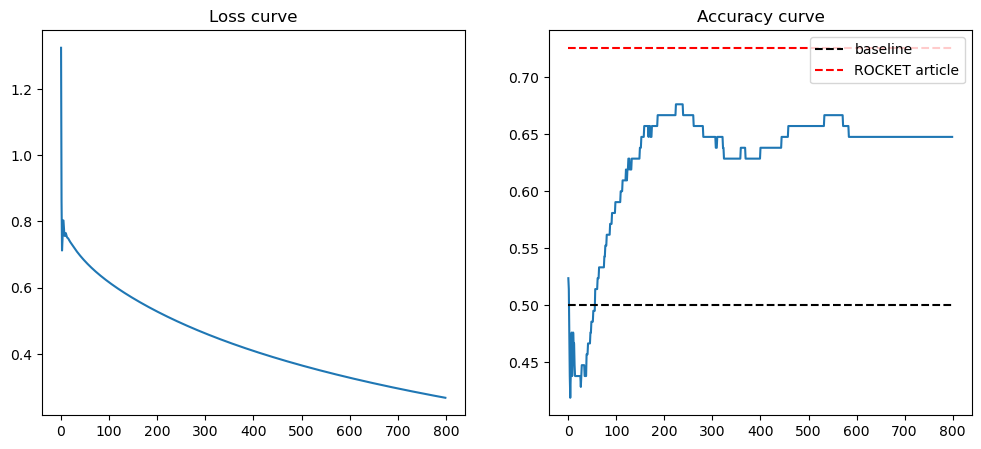

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].set_title('Loss curve')
ax[0].plot(losses_)

ax[1].set_title('Accuracy curve')
ax[1].plot(test_accuracy_)
ax[1].hlines(0.5, 0, 800, linestyle='dashed', color='black', label='baseline')
ax[1].hlines(0.7257, 0, 800, linestyle='dashed', color='red', label='ROCKET article')
ax[1].legend()

### 1. Comparison between kernels with $w \propto \mathcal{N} (0, 1)$, $w \in \{-1, 1\}$ and $w \in \{-1, 0, 1\}$

In [ ]:
N_attempts    = 200
epochs        = 250
lr            = 1e-5
n_kernels     = 10000
device        = 'cpu'

losses_norm = []
test_accuracy_norm = []
for attempt in tqdm(range(N_attempts)):
    model     = ClassifierModel(num_kernels=n_kernels, input_length=len(ham_train_dataset), device=device)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())

    losses_, test_accuracy_ = trainer(model, criterion, optimizer, epochs)
    losses_norm.append(losses_)
    test_accuracy_norm.append(test_accuracy_)

  0%|          | 0/200 [00:00<?, ?it/s]/var/folders/gn/shf0ms4j16nbyshj1ctvyv0m0000gn/T/ipykernel_42625/3062237364.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[index]), torch.tensor(self.Y[index])
100%|██████████| 200/200 [03:37<00:00,  1.09s/it]


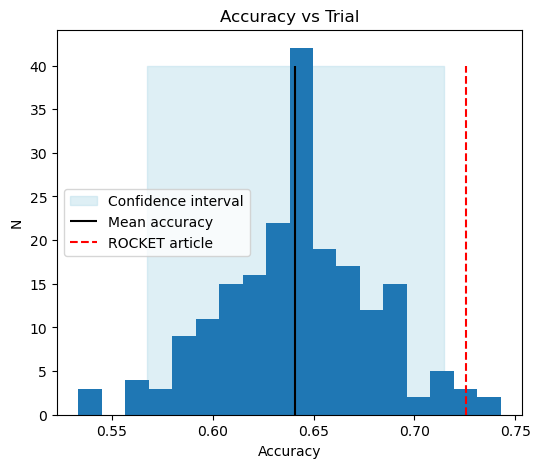

In [20]:
plt.figure(figsize=(6, 5))
plt.title('Accuracy vs Trial')

mean_norm = np.max(test_accuracy_norm, axis=1).mean()
std_norm = np.max(test_accuracy_norm, axis=1).std()

plt.fill_betweenx(y=[0, 40], x1=mean_norm - 1.96 * std_norm, x2=mean_norm + 1.96 * std_norm, color='lightblue', alpha=0.4, label='Confidence interval')
plt.hist(np.max(test_accuracy_norm, axis=1), bins=18)

plt.vlines(mean_norm, 0, 40, label='Mean accuracy', color='black')
plt.vlines(0.7257, 0, 40, linestyle='dashed', color='red', label='ROCKET article')

plt.xlabel('Accuracy')
plt.ylabel('N')
plt.legend()

In [ ]:
rt_transform = RocketTransform(num_kernels=10000, input_length=431, device='cpu', generation_type='binary')

ham_train_dataset = Ham_Dataset(rt_transform)
train_dataloader = torch.utils.data.DataLoader(ham_train_dataset, batch_size=16)

ham_test_dataset = Ham_Dataset(rt_transform, tsfile='Ham/Ham_TEST.ts')
test_dataloader =  torch.utils.data.DataLoader(ham_test_dataset, batch_size=len(ham_test_dataset))

N_attempts    = 200
epochs        = 250
lr            = 1e-5
n_kernels     = 10000
device        = 'cpu'

losses_bin = []
test_accuracy_bin = []
for attempt in tqdm(range(N_attempts)):
    model     = ClassifierModel(num_kernels=n_kernels, input_length=len(ham_train_dataset), device=device)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())

    losses_, test_accuracy_ = trainer(model, criterion, optimizer, epochs)
    losses_bin.append(losses_)
    test_accuracy_bin.append(test_accuracy_)

/Users/matvei_anosin/Desktop/Skoltech Interview /1/ROCKET_implementation.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0, torch.log2(torch.tensor((input_length - 1) / (length - 1), device=self.device))
  0%|          | 0/200 [00:00<?, ?it/s]/var/folders/gn/shf0ms4j16nbyshj1ctvyv0m0000gn/T/ipykernel_42625/3062237364.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[index]), torch.tensor(self.Y[index])
100%|██████████| 200/200 [03:41<00:00,  1.11s/it]


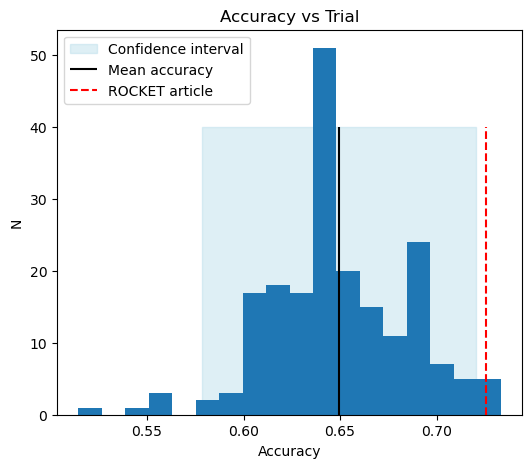

In [22]:
plt.figure(figsize=(6, 5))
plt.title('Accuracy vs Trial')

mean_bin = np.max(test_accuracy_bin, axis=1).mean()
std_bin = np.max(test_accuracy_bin, axis=1).std()

plt.fill_betweenx(y=[0, 40], x1=mean_bin - 1.96 * std_bin, x2=mean_bin + 1.96 * std_bin, color='lightblue', alpha=0.4, label='Confidence interval')
plt.hist(np.max(test_accuracy_bin, axis=1), bins=18)

plt.vlines(mean_bin, 0, 40, label='Mean accuracy', color='black')
plt.vlines(0.7257, 0, 40, linestyle='dashed', color='red', label='ROCKET article')

plt.xlabel('Accuracy')
plt.ylabel('N')
plt.legend()

In [ ]:
rt_transform = RocketTransform(num_kernels=10000, input_length=431, device='cpu', generation_type='ternary')

ham_train_dataset = Ham_Dataset(rt_transform)
train_dataloader = torch.utils.data.DataLoader(ham_train_dataset, batch_size=16)

ham_test_dataset = Ham_Dataset(rt_transform, tsfile='Ham/Ham_TEST.ts')
test_dataloader =  torch.utils.data.DataLoader(ham_test_dataset, batch_size=len(ham_test_dataset))

N_attempts    = 200
epochs        = 250
lr            = 1e-5
n_kernels     = 10000
device        = 'cpu'

losses_ter = []
test_accuracy_ter = []
for attempt in tqdm(range(N_attempts)):
    model     = ClassifierModel(num_kernels=n_kernels, input_length=len(ham_train_dataset), device=device)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())

    losses_, test_accuracy_ = trainer(model, criterion, optimizer, epochs)
    losses_ter.append(losses_)
    test_accuracy_ter.append(test_accuracy_)

/Users/matvei_anosin/Desktop/Skoltech Interview /1/ROCKET_implementation.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0, torch.log2(torch.tensor((input_length - 1) / (length - 1), device=self.device))
  0%|          | 0/200 [00:00<?, ?it/s]/var/folders/gn/shf0ms4j16nbyshj1ctvyv0m0000gn/T/ipykernel_42625/3062237364.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[index]), torch.tensor(self.Y[index])
100%|██████████| 200/200 [03:37<00:00,  1.09s/it]


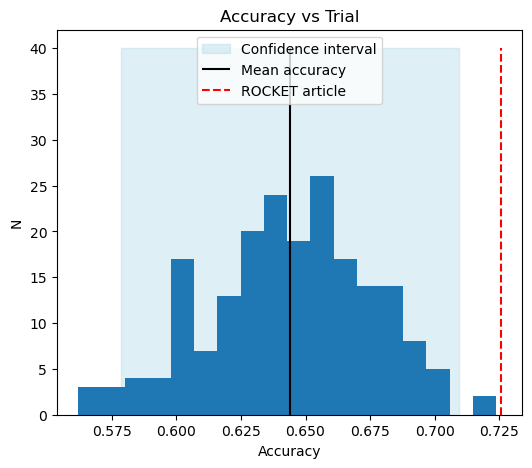

In [24]:
plt.figure(figsize=(6, 5))
plt.title('Accuracy vs Trial')

mean_ter = np.max(test_accuracy_ter, axis=1).mean()
std_ter = np.max(test_accuracy_ter, axis=1).std()

plt.fill_betweenx(y=[0, 40], x1=mean_ter - 1.96 * std_ter, x2=mean_ter + 1.96 * std_ter, color='lightblue', alpha=0.4, label='Confidence interval')
plt.hist(np.max(test_accuracy_ter, axis=1), bins=18)

plt.vlines(mean_ter, 0, 40, label='Mean accuracy', color='black')
plt.vlines(0.7257, 0, 40, linestyle='dashed', color='red', label='ROCKET article')

plt.xlabel('Accuracy')
plt.ylabel('N')
plt.legend()

<Axes: >

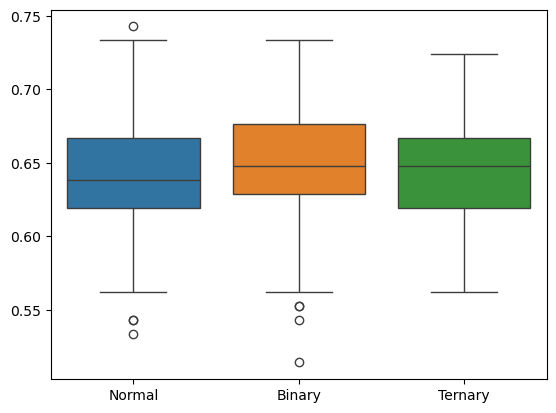

In [34]:
sns.boxplot(pd.DataFrame({'Normal'  : np.max(test_accuracy_norm, axis=1),
              'Binary'  : np.max(test_accuracy_bin, axis=1),
              'Ternary' : np.max(test_accuracy_ter, axis=1),}))

In [29]:
pd.DataFrame({'Normal'  : np.max(test_accuracy_norm, axis=1),
              'Binary'  : np.max(test_accuracy_bin, axis=1),
              'Ternary' : np.max(test_accuracy_ter, axis=1)}).corr()

,Normal,Binary,Ternary
Normal,1.000000,0.077832,-0.112730
Binary,0.077832,1.000000,-0.036436
Ternary,-0.112730,-0.036436,1.000000
